In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_rho_times_P_x_t_fn, CDF_v_change_till_stim_trunc_adj_fn, PDF_t_v_change
from scipy.integrate import trapezoid as trapz

# data

In [12]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

# VBMC

In [2]:
T_trunc = 0.3

In [3]:
def compute_loglike(row, base_V_A, theta_A, t_A_aff):
    t_stim = row['intended_fix']
    rt = row['timed_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']
    is_led_trial = row['LED_trial']

    trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, base_V_A, theta_A)

    if rt <= T_trunc:
        likelihood = 0
    else:
        if is_led_trial:
            if t_led == 0:
                likelihood = 1
            else:
                if t_led < T_trunc:
                    likelihood = 1
                else:
                    if rt < t_led:
                        likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                    else:
                        likelihood = (1 - cum_A_t_fn(t_led - t_A_aff, base_V_A, theta_A)) / trunc_factor
        else:
            if t_stim < T_trunc:
                likelihood = 1
            else:
                if rt < t_stim:
                    likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                else:
                    likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff, base_V_A, theta_A)) / trunc_factor
    
        

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, base_V_A, theta_A, t_A_aff)\
                                                    for _, row in df.iterrows())
                                        
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [4]:
base_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [-2, 0.09]

base_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0, 0.06]

# prior

In [5]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [6]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [9]:
lb = [base_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, theta_A_0, t_A_aff_0])

In [ ]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

In [ ]:
vp.save('post_led_censor_test_vbmc.pkl')

In [7]:
import pickle
with open('post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

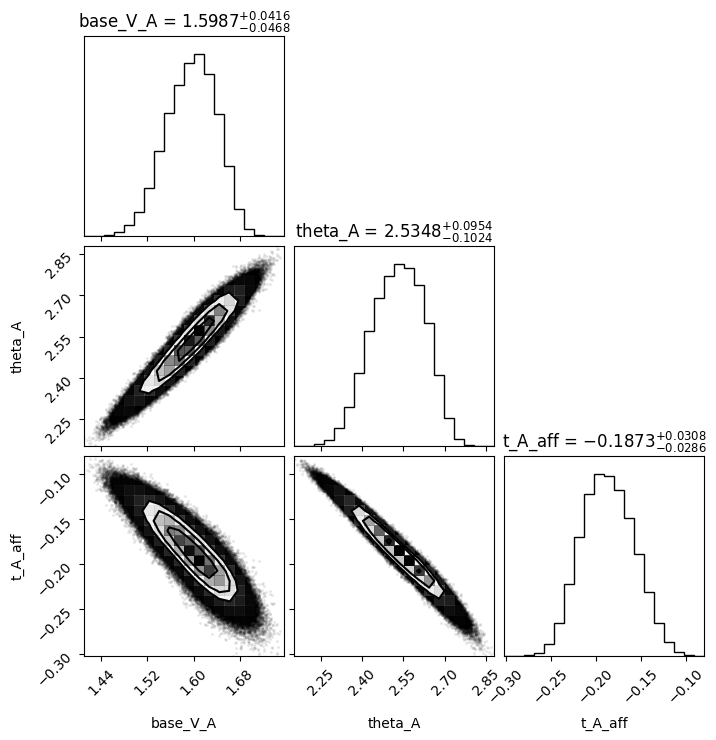

In [8]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


In [9]:
# from tqdm import tqdm
base_V_A_mean = np.mean(base_V_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)
theta_A_mean = np.mean(theta_A_samp)

# See Abort RT wrt LED distr in data

In [13]:
# data LED ON and LED OFF 

df_led_on_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]


led_on_aborts_wrt_led = df_led_on_aborts['timed_fix'] - (df_led_on_aborts['intended_fix'] - df_led_on_aborts['LED_onset_time'])
led_off_aborts_wrt_led = df_led_off_aborts['timed_fix'] - (df_led_off_aborts['intended_fix'] - df_led_off_aborts['LED_onset_time'])

Text(0.5, 1.0, 'Data')

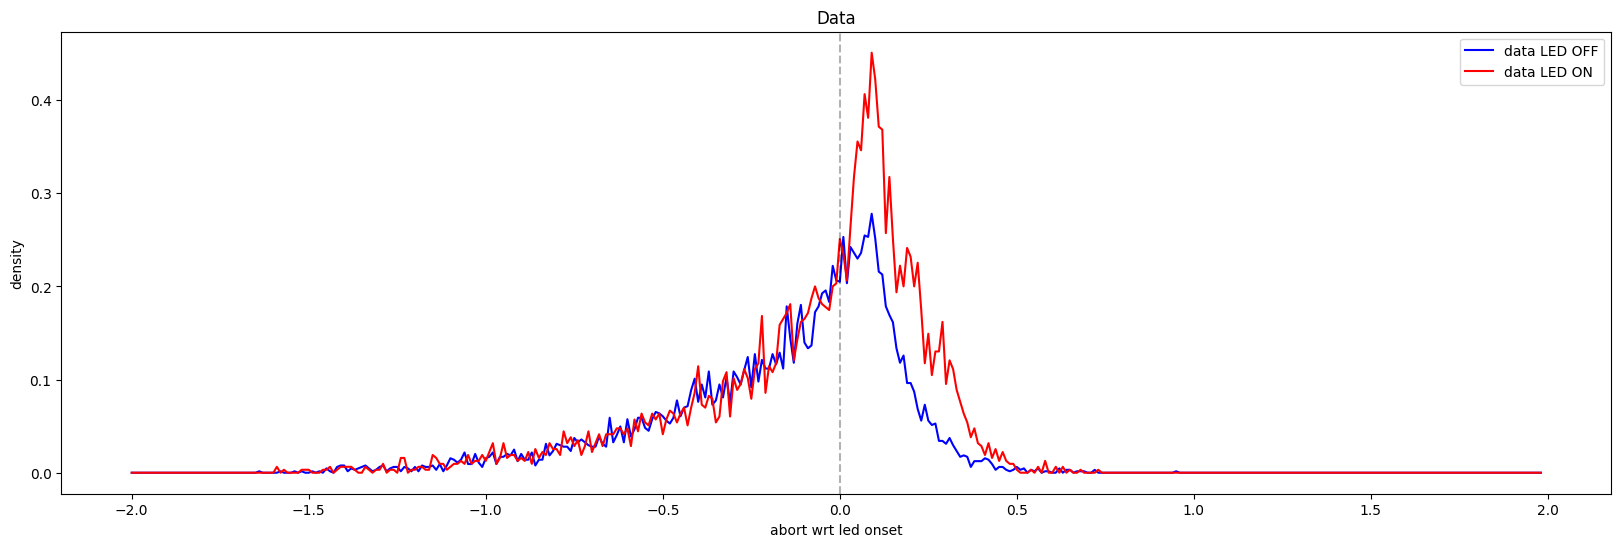

In [14]:
dt_data = 0.01
t_pts_data = np.arange(-2, 2, dt_data)

### OFF ### 
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[ df['LED_trial'] == 0]))


### ON ###
on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[ df['LED_trial'] == 1]))

plt.figure(figsize=(20, 6))
plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')


plt.legend()
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.xlabel('abort wrt led onset')
plt.ylabel('density')
plt.title('Data')

# increase in V_A drift after LED

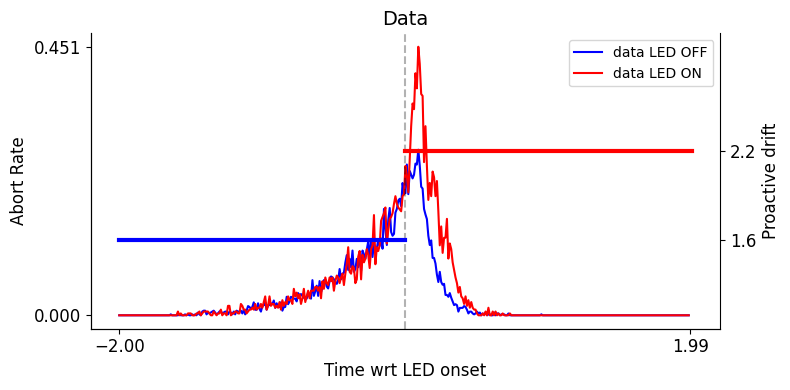

In [15]:
import numpy as np
import matplotlib.pyplot as plt

dt_data = 0.01
t_pts_data = np.arange(-2, 2, dt_data)

# Histograms (scale by proportion)
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[df['LED_trial'] == 0]))

on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[df['LED_trial'] == 1]))

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
ax1.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')
ax1.axvline(0, color='k', ls='--', alpha=0.3)

ax1.set_xlabel('Time wrt LED onset', fontsize=12)
ax1.set_ylabel('Abort Rate', fontsize=12)
ax1.set_title('Data', fontsize=14)
ax1.legend()

# Minimize x-ticks (just two)
ax1.set_xticks([t_pts_data[0], t_pts_data[-1]])

# Minimize y-ticks on the left
ymax = max(off_hist.max(), on_hist.max())
ax1.set_yticks([0, ymax])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=12)

# # Right axis for Proactive Drift
ax2 = ax1.twinx()

# Blue horizontal line before x=0 (1.6), red after x=0 (2.2)
ax2.plot([-2, 0], [1.6, 1.6], color='blue', lw=3)
ax2.plot([0, 2], [2.2, 2.2], color='red', lw=3)

# Limit and ticks on right y-axis (2 ticks)
ax2.set_ylim(1.0, 3.0)
ax2.set_yticks([1.6, 2.2])
ax2.set_ylabel("Proactive drift", fontsize=12)

ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# grids to see motor delay

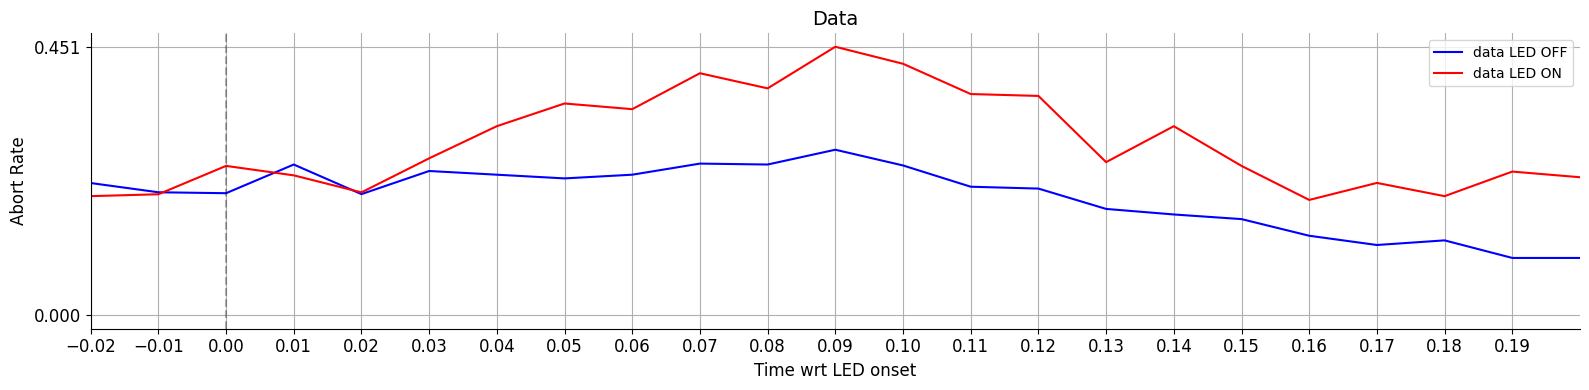

In [16]:
import numpy as np
import matplotlib.pyplot as plt

dt_data = 0.01
t_pts_data = np.arange(-2, 2, dt_data)

# Histograms (scale by proportion)
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[df['LED_trial'] == 0]))

on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[df['LED_trial'] == 1]))

fig, ax1 = plt.subplots(figsize=(16, 4))

ax1.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
ax1.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')
ax1.axvline(0, color='k', ls='--', alpha=0.3)

ax1.set_xlabel('Time wrt LED onset', fontsize=12)
ax1.set_ylabel('Abort Rate', fontsize=12)
ax1.set_title('Data', fontsize=14)
ax1.legend()

# Commenting out the old minimal x-ticks:
# ax1.set_xticks([t_pts_data[0], t_pts_data[-1]])

# New x-ticks from -0.5 to 0.5 in steps of 0.05:
ax1.set_xticks(np.arange(-0.02, 0.2, 0.01))
ax1.set_xlim([-0.02, 0.2])

# Minimize y-ticks on the left
ymax = max(off_hist.max(), on_hist.max())
ax1.set_yticks([0, ymax])

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add grid
ax1.grid(True)

ax1.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# compare with V_A change but simulation, NOT theory

In [17]:
dt = 1e-3; dB = np.sqrt(dt)
def simulate_v_change_pro(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; new_v = sim_params['new_v']; aff = sim_params['aff'] 
    t_led = sim_params['t_led'];
    
    dv = 0
    motor_delay = 0.04 # obtained visually from the data histogram
    t = aff - motor_delay      
    while True:
        if t > t_led:
            v = new_v
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            return t + motor_delay, sim_params
        

def simulate_single_bound(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; aff = sim_params['aff']
    dv = 0; t = 0
    while True:
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            return t + aff, sim_params
        

def filter_sim_res(all_res):
    rts_wrt_led = []
    num_aborts = 0
    for res in all_res:
        rt = res[0]
        params = res[1]

        t_led = params['t_led']
        t_stim = params['t_stim']

        if rt > T_trunc and rt < t_stim:
            num_aborts += 1
            rts_wrt_led.append(rt - t_led)
        
    
    frac_aborts = num_aborts / len(all_res)
    return rts_wrt_led, frac_aborts

base v 1.5963371625628608, theta 2.531556333497211, t_aff -0.18648768975611416
new_v 1.5963371625628608, base_V_A_mean 1.5963371625628608


frac_aborts sim 0.127296
area under sim 0.127296
area under data off 0.1266135421035463
area under data on 0.16371316056910568
new_v 3.396337162562861, base_V_A_mean 1.5963371625628608


/tmp/ipykernel_1196738/1653240888.py:49: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  print(f'area under sim {trapz(rts_wrt_led_hist, t_pts[:-1])}')
/tmp/ipykernel_1196738/1653240888.py:50: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  print(f'area under data off {trapz(off_hist, t_pts_data[:-1])}')
/tmp/ipykernel_1196738/1653240888.py:51: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  print(f'area under data on {trapz(on_hist, t_pts_data[:-1])}')
/tmp/ipykernel_1196738/1653240888.py:74: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  plt.title(f'40ms motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area

frac_aborts sim 0.163958
area under sim 0.16395799999999996
area under data off 0.1266135421035463
area under data on 0.16371316056910568


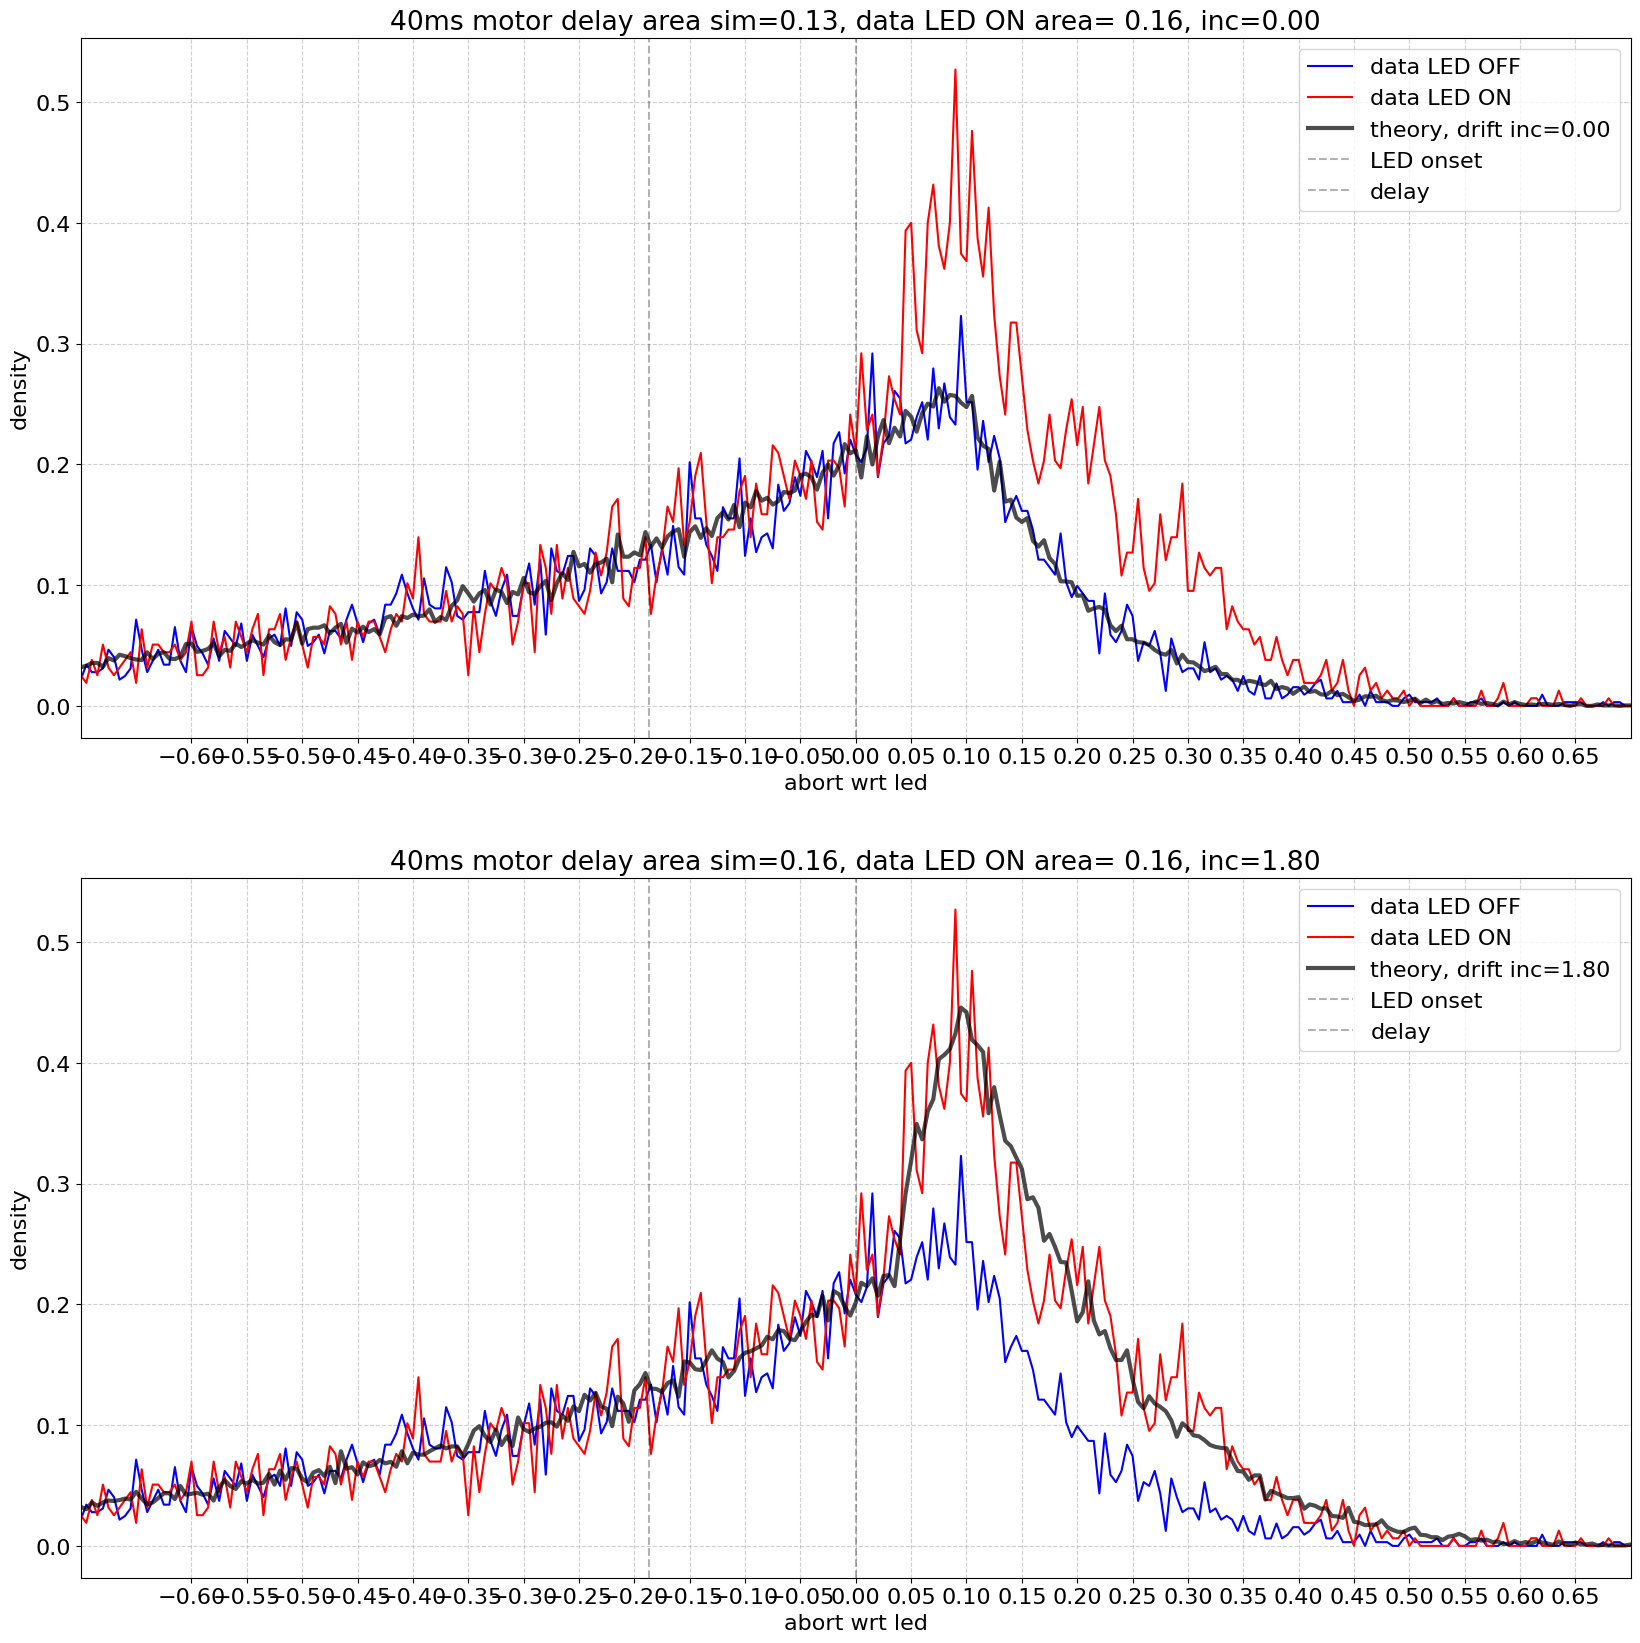

In [19]:
N_sample = int(500e3)
sampled_df = df[['intended_fix', 'LED_onset_time']].sample(n=N_sample, random_state=42, replace=True).reset_index()

sampled_df['t_stim'] = sampled_df['intended_fix']
sampled_df['t_led'] = sampled_df['intended_fix'] - sampled_df['LED_onset_time']

plt.figure(figsize=(20,20))
# theory
time_bin = 0.005; T_max = 1.5
t_pts = np.arange(-2, 2, time_bin)

# data
dt_data = 0.005
t_pts_data = np.arange(-2, 2, dt_data)

### OFF ### 
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[ df['LED_trial'] == 0]))
### ON ###
on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[ df['LED_trial'] == 1]))

print(f'base v {base_V_A_mean}, theta {theta_A_mean}, t_aff {t_A_aff_mean}')
steps = [0, 1.8]
f = 1
for step in steps:
    
    new_v = base_V_A_mean + step 

    print(f'new_v {new_v}, base_V_A_mean {base_V_A_mean}')
    sim_res = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )

    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)
    print(f'frac_aborts sim {frac_aborts}')
    rts_wrt_led_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_wrt_led_hist *= frac_aborts

    print(f'area under sim {trapz(rts_wrt_led_hist, t_pts[:-1])}')
    print(f'area under data off {trapz(off_hist, t_pts_data[:-1])}')   
    print(f'area under data on {trapz(on_hist, t_pts_data[:-1])}')  

    plt.subplot(len(steps), 1, f)
    # data
    plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
    plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

    # theory
    plt.plot(t_pts[:-1], rts_wrt_led_hist, label=f'theory, drift inc={step:.2f}', lw=3, color='k', alpha=0.7)
    plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    plt.xlabel('abort wrt led')
    plt.ylabel('density')
    plt.xlim(-0.7, 0.7)
    plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    plt.legend()

    # Adding more x-ticks
    xticks = np.arange(-0.6, 0.7, 0.05)  # Customize the number of ticks if needed
    plt.xticks(xticks)

    # Adding grids
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.title(f'40ms motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area= {trapz(on_hist, t_pts_data[:-1]):.2f}, inc={step:.2f}')
    f += 1



# Design changes:

In [21]:
# ================================
# PART A: SIMULATION & SAVING
# ================================

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.integrate import trapz

# --- Simulation parameters ---
N_sample = int(500e3)
steps = [0, 1.8]

# --- Sample the data (example) ---
sampled_df = df[['intended_fix', 'LED_onset_time']].sample(
    n=N_sample, random_state=42, replace=True
).reset_index()

sampled_df['t_stim'] = sampled_df['intended_fix']
sampled_df['t_led']  = sampled_df['intended_fix'] - sampled_df['LED_onset_time']

# --- Define time points for histograms ---
t_pts      = np.arange(-2, 2, 0.005)  # theory bin edges
t_pts_data = np.arange(-2, 2, 0.005)  # data bin edges

# --- Compute 'OFF' and 'ON' histograms from your actual data ---
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[df['LED_trial'] == 0]))

on_hist, _  = np.histogram(led_on_aborts_wrt_led,  bins=t_pts_data, density=True)
on_hist  *= (len(led_on_aborts_wrt_led) / len(df[df['LED_trial'] == 1]))

# --- Prepare a dictionary to store everything ---
results_dict = {
    'steps': steps,
    't_pts': t_pts,
    't_pts_data': t_pts_data,
    'off_hist': off_hist,
    'on_hist': on_hist,
    'base_V_A_mean': base_V_A_mean,
    'theta_A_mean':   theta_A_mean,
    't_A_aff_mean':   t_A_aff_mean,
    'sim_results': {}
}

# --- Run simulations for each step and store ---
for step in steps:
    new_v = base_V_A_mean + step
    
    # Run your simulation in parallel
    sim_res = Parallel(n_jobs=30)(
        delayed(simulate_v_change_pro)({
            'v':     base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff':   t_A_aff_mean,
            't_led':  sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        })
        for idx in range(N_sample)
    )

    # Extract RTs w.r.t LED and fraction of aborts
    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)

    # Bin the simulated RTs and multiply by fraction of aborts
    rts_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_hist    = rts_hist * frac_aborts

    # Save
    results_dict['sim_results'][step] = {
        'rts_wrt_led_hist': rts_hist,
        'frac_aborts': frac_aborts
    }

# --- Save results to a file ---
np.save('abort_sim_results.npy', results_dict)
print("Simulation results saved to 'abort_sim_results.npy'.")


Simulation results saved to 'abort_sim_results.npy'.


/tmp/ipykernel_1196738/3361977877.py:34: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_sim         = trapz(rts_wrt_led_hist, t_pts[:-1])
/tmp/ipykernel_1196738/3361977877.py:35: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_data_off    = trapz(off_hist, t_pts_data[:-1])
/tmp/ipykernel_1196738/3361977877.py:36: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_data_on     = trapz(on_hist,  t_pts_data[:-1])


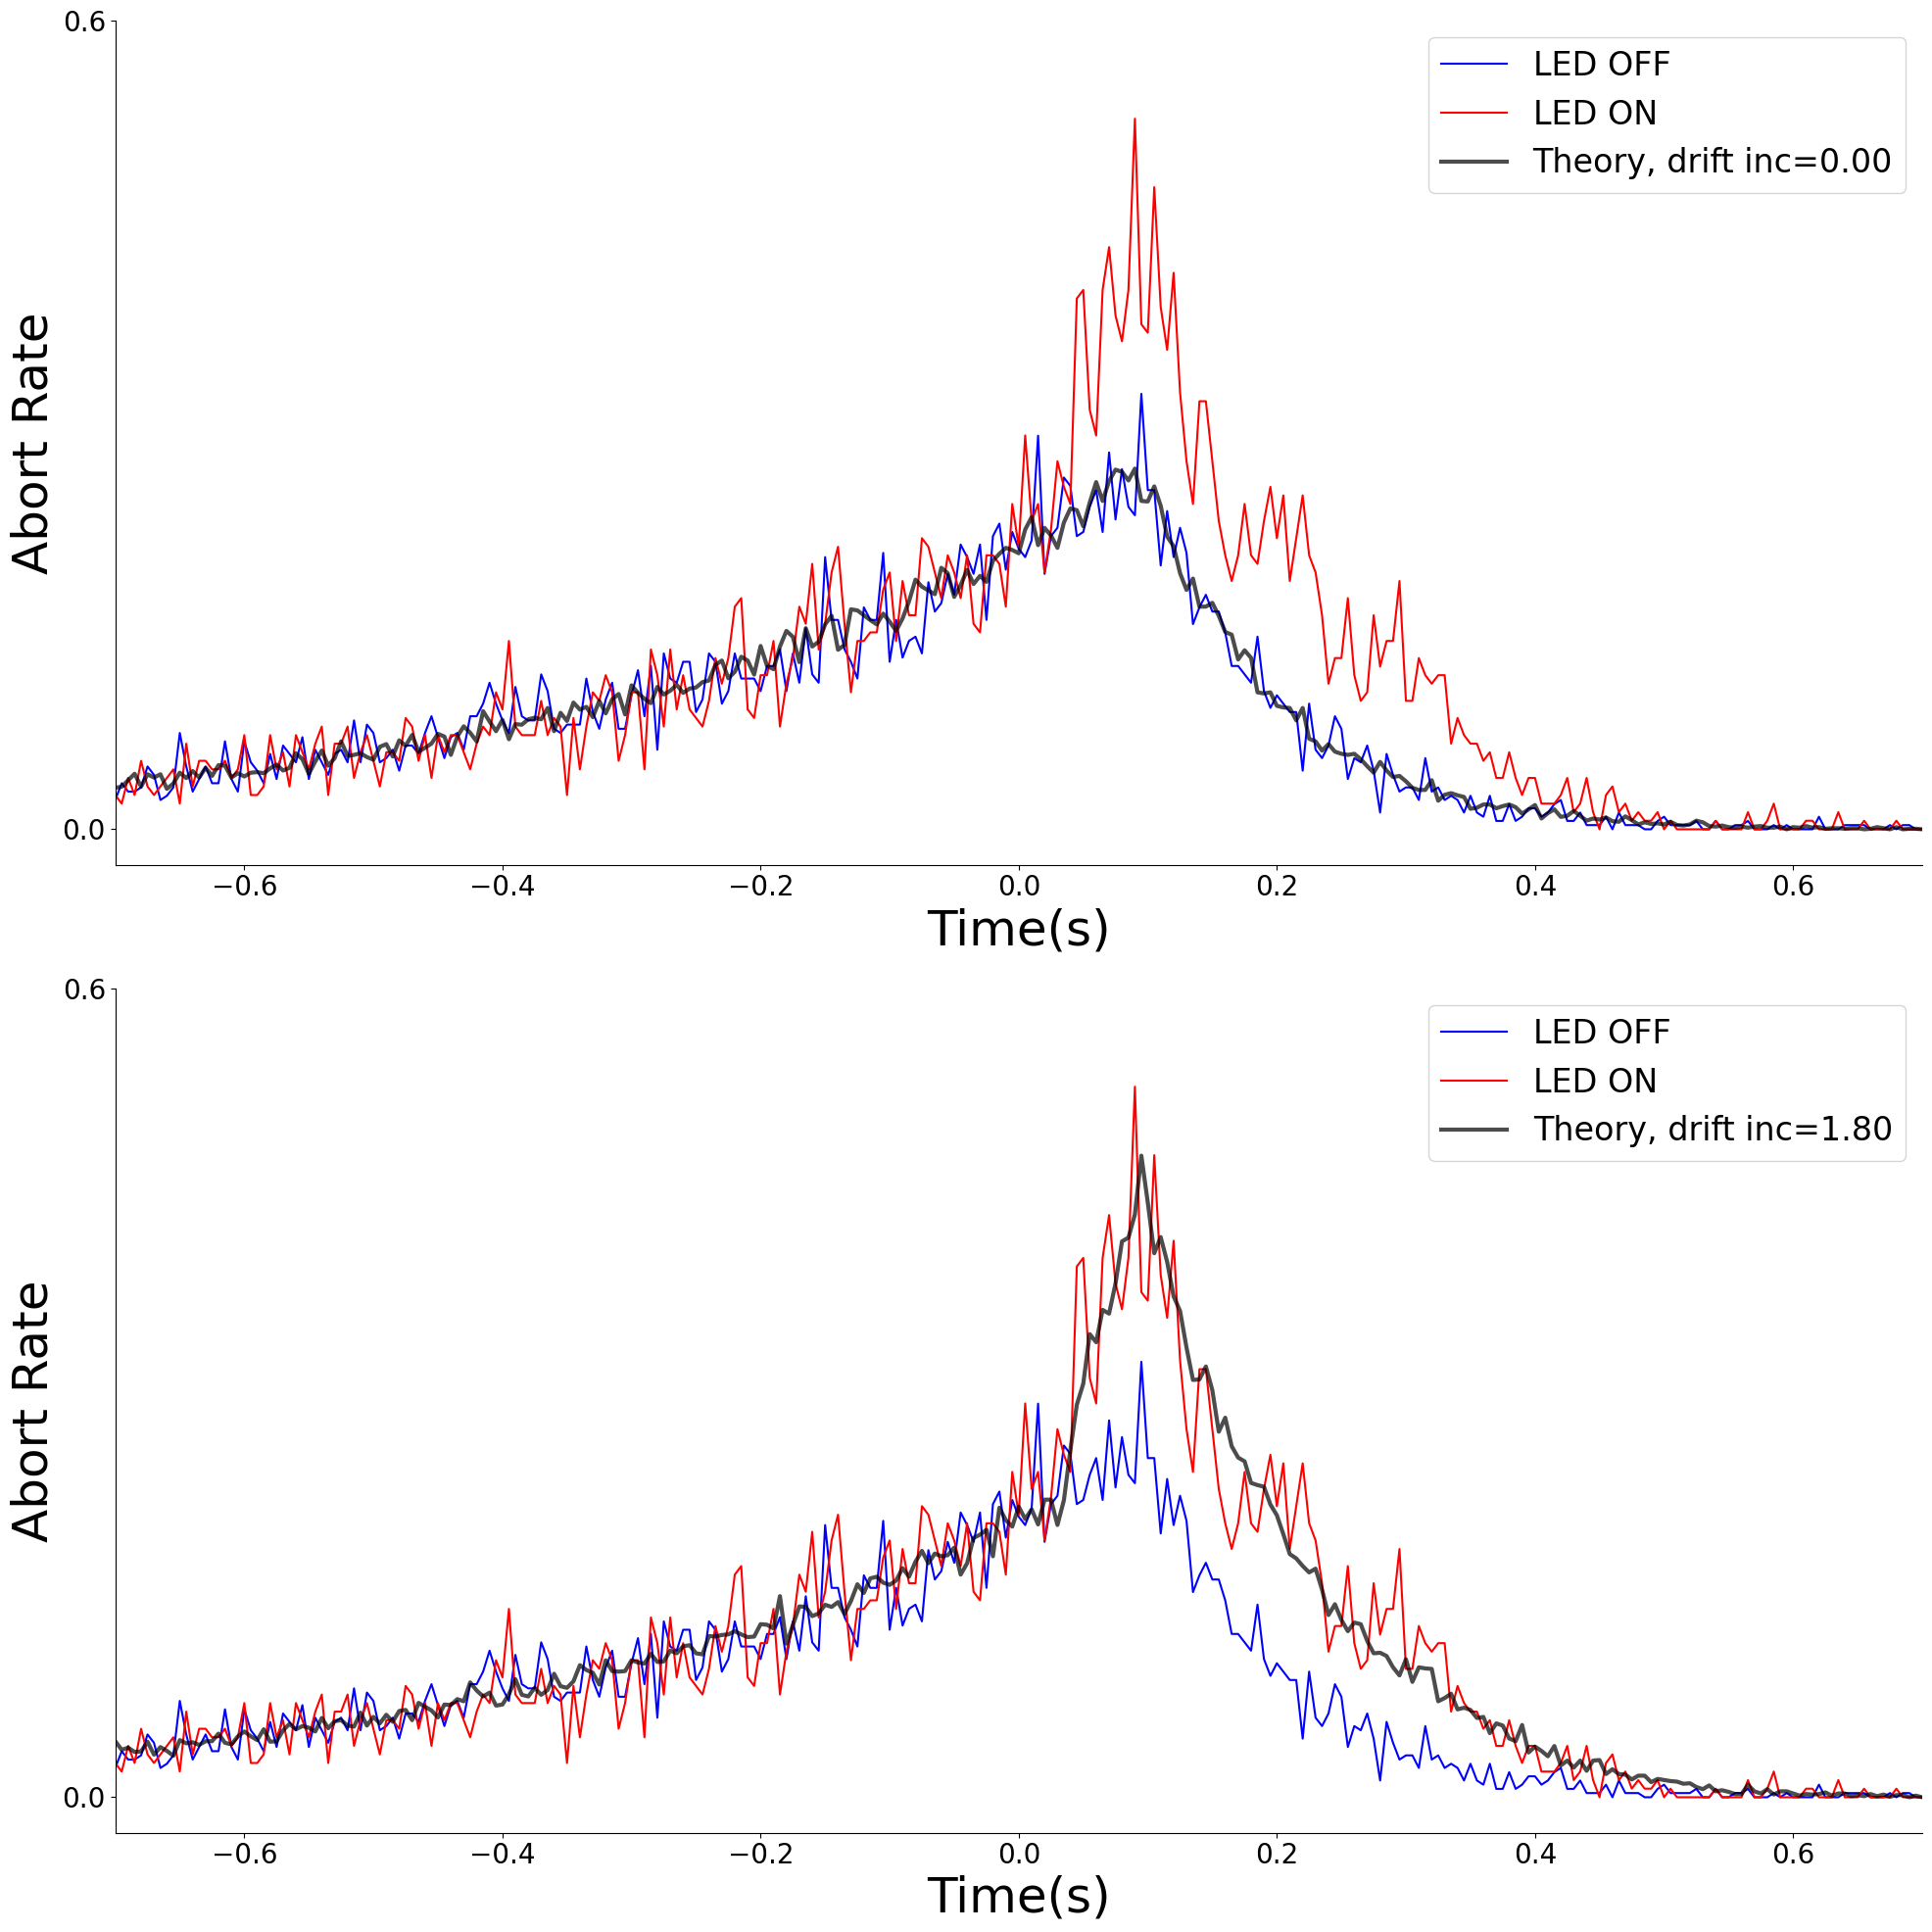

In [30]:
# ================================
# PART B: PLOTTING (UPDATED)
# ================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# --- Load the dictionary ---
results_dict = np.load('abort_sim_results.npy', allow_pickle=True).item()

# --- Unpack everything ---
steps         = results_dict['steps']
t_pts         = results_dict['t_pts']
t_pts_data    = results_dict['t_pts_data']
off_hist      = results_dict['off_hist']
on_hist       = results_dict['on_hist']
base_V_A_mean = results_dict['base_V_A_mean']
theta_A_mean  = results_dict['theta_A_mean']
t_A_aff_mean  = results_dict['t_A_aff_mean']
sim_results   = results_dict['sim_results']

# --- Increase default font size ---
plt.rcParams['font.size'] = 16

# --- Create the figure ---
plt.figure(figsize=(20, 20))

for i, step in enumerate(steps, start=1):
    ax = plt.subplot(len(steps), 1, i)
    
    # Retrieve simulation histogram and calculate areas
    rts_wrt_led_hist = sim_results[step]['rts_wrt_led_hist']
    area_sim         = trapz(rts_wrt_led_hist, t_pts[:-1])
    area_data_off    = trapz(off_hist, t_pts_data[:-1])
    area_data_on     = trapz(on_hist,  t_pts_data[:-1])

    # --- Plot data histograms ---
    plt.plot(t_pts_data[:-1], off_hist, label='LED OFF', color='b')
    plt.plot(t_pts_data[:-1], on_hist,  label='LED ON',  color='r')

    # --- Plot simulation ---
    plt.plot(t_pts[:-1], rts_wrt_led_hist, 
             label=f'Theory, drift inc={step:.2f}', 
             lw=3, color='k', alpha=0.7)

    # Remove the vertical line for LED onset (commented out)
    # plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    
    # Optionally remove or keep the 'delay' line:
    # plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)

    # Change labels
    plt.xlabel('Time(s)', fontsize=36)
    plt.ylabel('Abort Rate', fontsize=36)
    plt.xlim([-0.7, 0.7])

    # Only y-ticks at 0 and 0.6
    plt.yticks([0, 0.6])

    # Remove the title
    # (Comment or remove any plt.title(...) calls)
    # plt.title(...)

    # Keep only x-axis and y-axis (remove top/right spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # If you previously removed all spines, make sure bottom/left are visible:
    # ax.spines['bottom'].set_visible(True)
    # ax.spines['left'].set_visible(True)

    # Legend with bigger font
    plt.legend(fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)







    # leg.fontsize(16)  # Increase legend font size

plt.tight_layout()
plt.show()


# prev plot with corner plot

/tmp/ipykernel_1196738/2375641248.py:47: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_sim         = trapz(rts_wrt_led_hist, t_pts[:-1])
/tmp/ipykernel_1196738/2375641248.py:48: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_data_off    = trapz(off_hist, t_pts_data[:-1])
/tmp/ipykernel_1196738/2375641248.py:49: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_data_on     = trapz(on_hist,  t_pts_data[:-1])


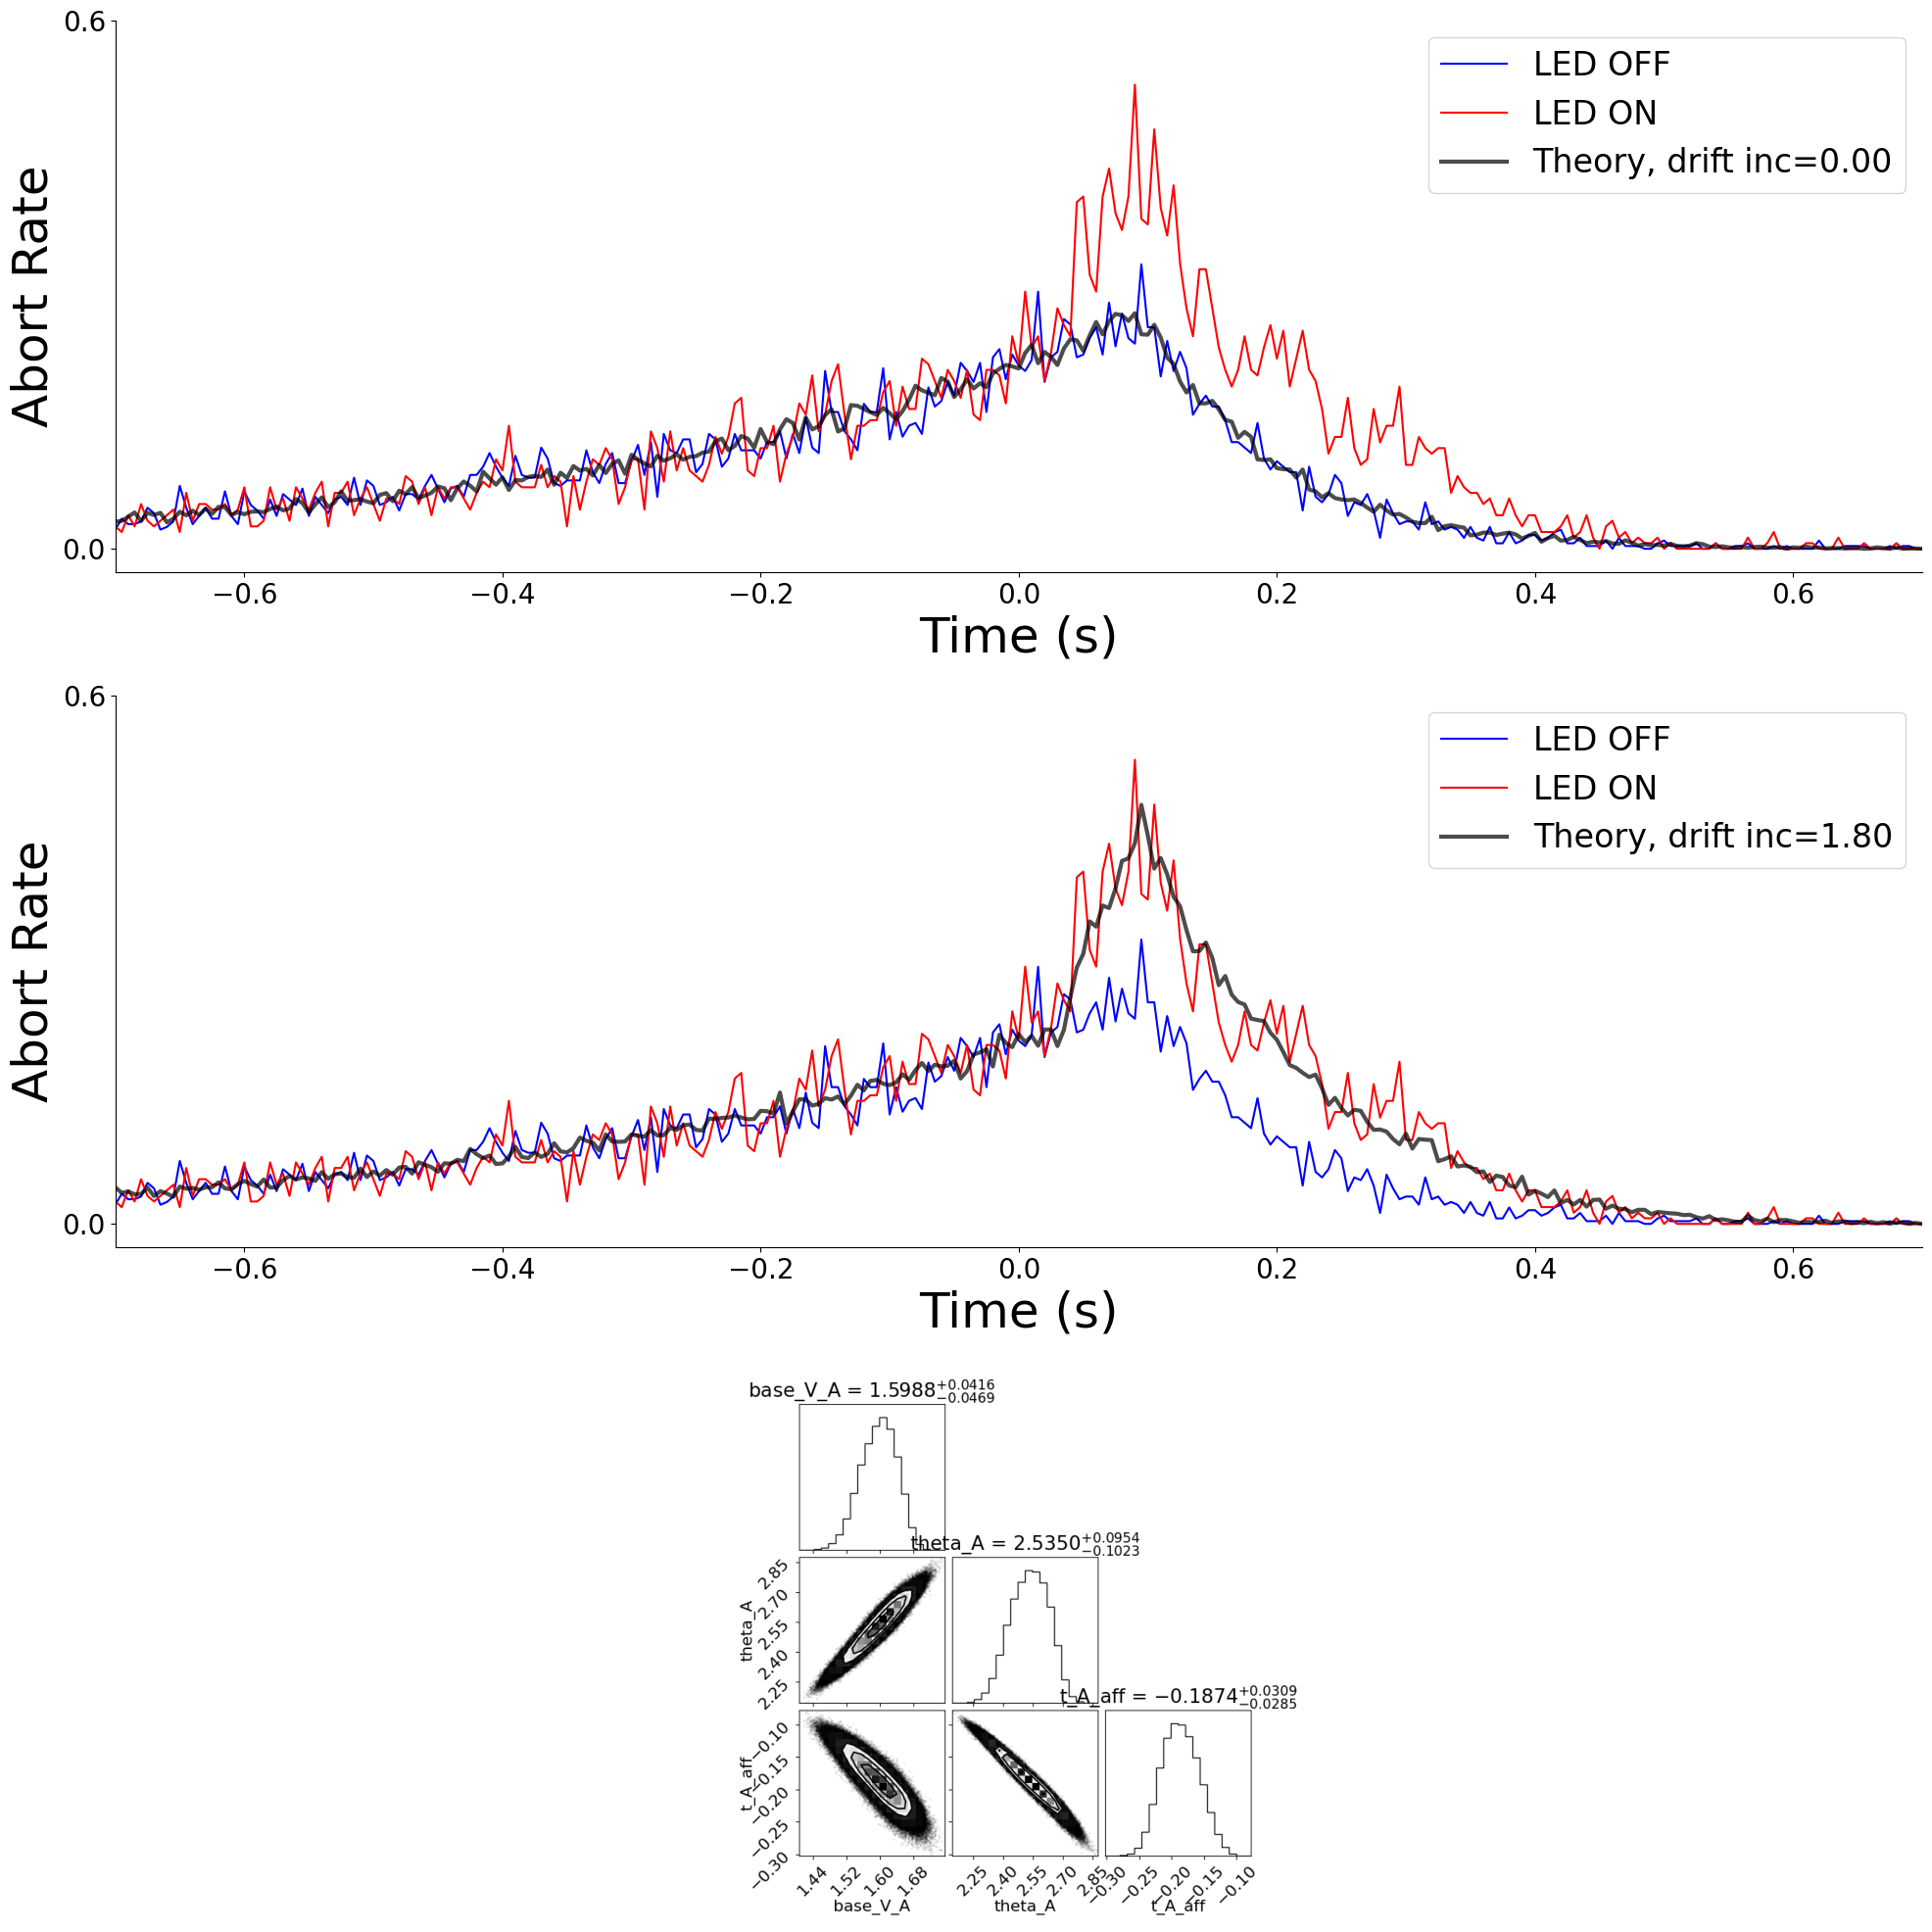

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import trapz
import corner
import io

# --- Load the dictionary with simulation results ---
results_dict = np.load('abort_sim_results.npy', allow_pickle=True).item()

# --- Unpack simulation results ---
steps         = results_dict['steps']
t_pts         = results_dict['t_pts']
t_pts_data    = results_dict['t_pts_data']
off_hist      = results_dict['off_hist']
on_hist       = results_dict['on_hist']
base_V_A_mean = results_dict['base_V_A_mean']
theta_A_mean  = results_dict['theta_A_mean']
t_A_aff_mean  = results_dict['t_A_aff_mean']
sim_results   = results_dict['sim_results']

# --- Load parameter samples for the corner plot ---
# (Assuming that vp is defined and is a valid sampling object.)
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:, 0]
theta_A_samp = vp_samples[:, 1]
t_A_aff_samp = vp_samples[:, 2]

combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'theta_A', 't_A_aff']

# --- Increase default font sizes ---
plt.rcParams['font.size'] = 16

# --- Set up the overall figure with GridSpec ---
n_sim_plots = len(steps)
n_total_rows = n_sim_plots + 1  # extra row for the corner plot
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(n_total_rows, 1, height_ratios=[1]*n_sim_plots + [1])

# --- Create simulation subplots in the top part of the figure ---
for i, step in enumerate(steps):
    ax = fig.add_subplot(gs[i, 0])
    
    # Retrieve simulation histogram and calculate areas
    rts_wrt_led_hist = sim_results[step]['rts_wrt_led_hist']
    area_sim         = trapz(rts_wrt_led_hist, t_pts[:-1])
    area_data_off    = trapz(off_hist, t_pts_data[:-1])
    area_data_on     = trapz(on_hist,  t_pts_data[:-1])
    
    # Plot data histograms
    ax.plot(t_pts_data[:-1], off_hist, label='LED OFF', color='b')
    ax.plot(t_pts_data[:-1], on_hist,  label='LED ON',  color='r')
    
    # Plot simulation result
    ax.plot(t_pts[:-1], rts_wrt_led_hist, label=f'Theory, drift inc={step:.2f}', 
            lw=3, color='k', alpha=0.7)
    
    # (Optional vertical lines)
    # ax.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    # ax.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    
    # Set labels and limits
    ax.set_xlabel('Time (s)', fontsize=36)
    ax.set_ylabel('Abort Rate', fontsize=36)
    ax.set_xlim([-0.7, 0.7])
    ax.set_yticks([0, 0.6])
    
    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend and tick label sizes
    ax.legend(fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)

# --- Generate the corner plot in a temporary figure ---
temp_fig = corner.corner(combined_samples, labels=param_labels, show_titles=True, 
                           title_fmt=".4f", verbose=False)

# Save the temporary corner plot to a bytes buffer as a PNG image
buf = io.BytesIO()
temp_fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
corner_img = plt.imread(buf)
plt.close(temp_fig)  # close the temporary figure

# --- Insert the corner plot image into the bottom GridSpec cell ---
ax_corner = fig.add_subplot(gs[-1, 0])
ax_corner.imshow(corner_img)
ax_corner.axis('off')  # remove ticks and spines

# --- Adjust layout and save the combined figure as a PDF ---
plt.tight_layout()
plt.savefig("combined_plot.pdf")
plt.show()


# Trying with different steps - rough - for presentation

base v 1.5964451820360184, theta 2.531805842508095, t_aff -0.18656712803200454
new_v 1.5964451820360184, base_V_A_mean 1.5964451820360184


frac_aborts sim 0.126826
area under sim 0.126826
area under data off 0.1266135421035463
area under data on 0.16371316056910568
new_v 2.7964451820360186, base_V_A_mean 1.5964451820360184
frac_aborts sim 0.14945
area under sim 0.14945000000000003
area under data off 0.1266135421035463
area under data on 0.16371316056910568
new_v 2.9964451820360183, base_V_A_mean 1.5964451820360184
frac_aborts sim 0.153878
area under sim 0.153878
area under data off 0.1266135421035463
area under data on 0.16371316056910568
new_v 3.396445182036018, base_V_A_mean 1.5964451820360184
frac_aborts sim 0.16332
area under sim 0.16332
area under data off 0.1266135421035463
area under data on 0.16371316056910568


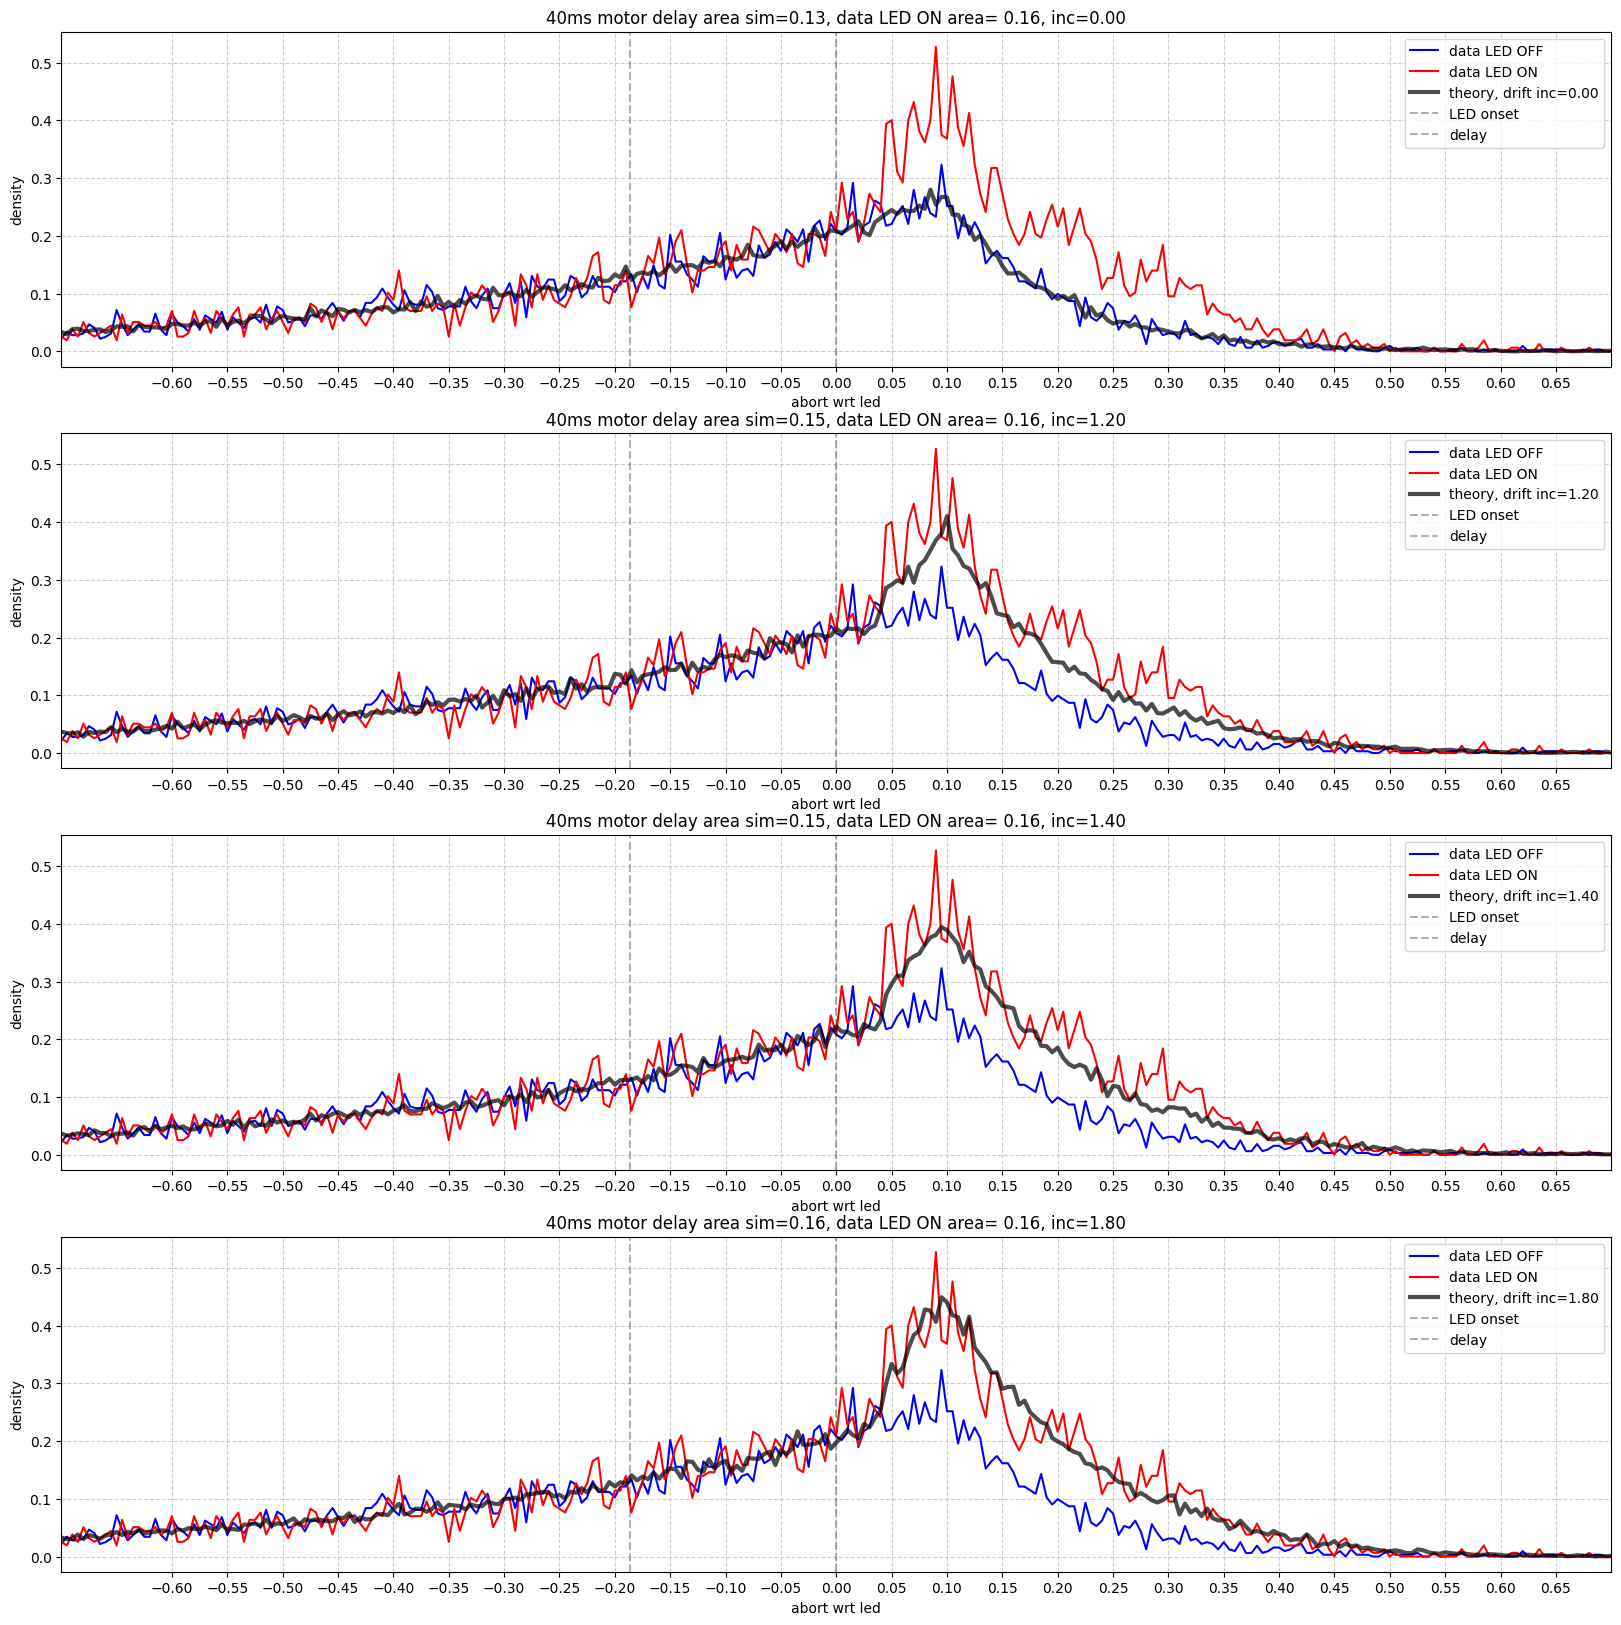

In [24]:
N_sample = int(500e3)
sampled_df = df[['intended_fix', 'LED_onset_time']].sample(n=N_sample, random_state=42, replace=True).reset_index()

sampled_df['t_stim'] = sampled_df['intended_fix']
sampled_df['t_led'] = sampled_df['intended_fix'] - sampled_df['LED_onset_time']

plt.figure(figsize=(20,20))
# theory
time_bin = 0.005; T_max = 1.5
t_pts = np.arange(-2, 2, time_bin)

# data
dt_data = 0.005
t_pts_data = np.arange(-2, 2, dt_data)

### OFF ### 
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[ df['LED_trial'] == 0]))
### ON ###
on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[ df['LED_trial'] == 1]))

print(f'base v {base_V_A_mean}, theta {theta_A_mean}, t_aff {t_A_aff_mean}')
steps = [0, 1.2, 1.4, 1.8]
f = 1
for step in steps:
    
    new_v = base_V_A_mean + step 

    print(f'new_v {new_v}, base_V_A_mean {base_V_A_mean}')
    sim_res = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )

    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)
    print(f'frac_aborts sim {frac_aborts}')
    rts_wrt_led_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_wrt_led_hist *= frac_aborts

    print(f'area under sim {trapz(rts_wrt_led_hist, t_pts[:-1])}')
    print(f'area under data off {trapz(off_hist, t_pts_data[:-1])}')   
    print(f'area under data on {trapz(on_hist, t_pts_data[:-1])}')  

    plt.subplot(len(steps), 1, f)
    # data
    plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
    plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

    # theory
    plt.plot(t_pts[:-1], rts_wrt_led_hist, label=f'theory, drift inc={step:.2f}', lw=3, color='k', alpha=0.7)
    plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    plt.xlabel('abort wrt led')
    plt.ylabel('density')
    plt.xlim(-0.7, 0.7)
    plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    plt.legend()

    # Adding more x-ticks
    xticks = np.arange(-0.6, 0.7, 0.05)  # Customize the number of ticks if needed
    plt.xticks(xticks)

    # Adding grids
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.title(f'40ms motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area= {trapz(on_hist, t_pts_data[:-1]):.2f}, inc={step:.2f}')
    f += 1



# Experiment with diff motor delays in LED on and off

In [21]:
def simulate_v_change_pro_v20(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; new_v = sim_params['new_v']; aff = sim_params['aff'] 
    t_led = sim_params['t_led'];
    
    dv = 0
    # t = aff - 0.04      
    t = aff
    while True:
        if t > t_led:
            v = new_v
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            # return t + 0.04, sim_params
            if t < t_led:
                return t + 0, sim_params
            else:
                return t + 0.04, sim_params
        

new_v 3.396381806717504, base_V_A_mean 1.5963818067175037
frac_aborts sim 0.162894
frac_aborts sim 1 0.150294


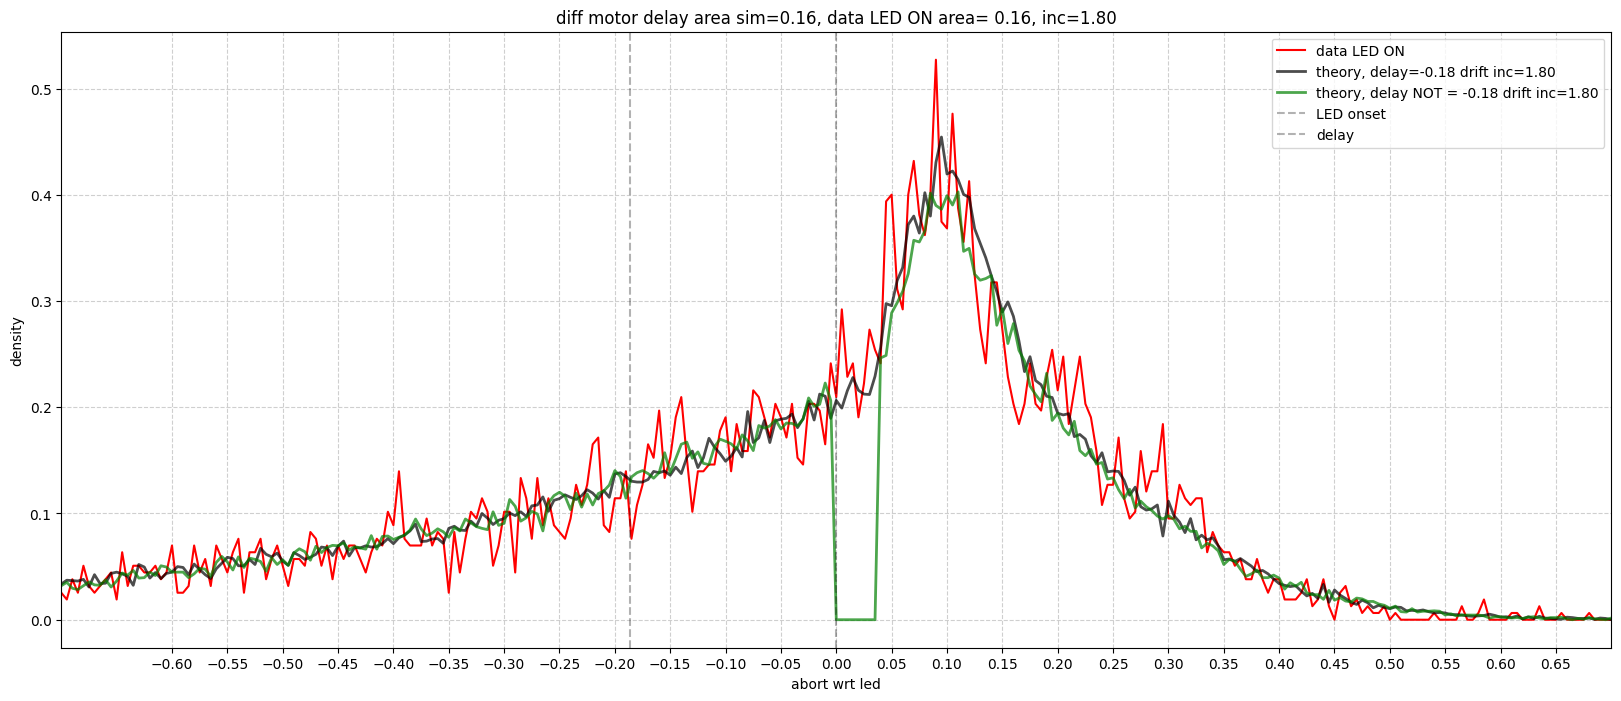

In [22]:
steps = [1.8]
f = 1
plt.figure(figsize=(20,8))
for step in steps:
    
    new_v = base_V_A_mean + step 

    print(f'new_v {new_v}, base_V_A_mean {base_V_A_mean}')
    sim_res = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )

    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)
    print(f'frac_aborts sim {frac_aborts}')
    rts_wrt_led_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_wrt_led_hist *= frac_aborts

    sim_res_1 = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro_v20)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )
    rts_wrt_led_1, frac_aborts_1 = filter_sim_res(sim_res_1)
    print(f'frac_aborts sim 1 {frac_aborts_1}')
    rts_wrt_led_hist_1, _ = np.histogram(rts_wrt_led_1, bins=t_pts, density=True)
    rts_wrt_led_hist_1 *= frac_aborts_1


    plt.subplot(len(steps), 1, f)
    # data
    plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

    # theory
    plt.plot(t_pts[:-1], rts_wrt_led_hist, label=f'theory, delay=-0.18 drift inc={step:.2f}', color='k', alpha=0.7, lw=2)
    plt.plot(t_pts[:-1], rts_wrt_led_hist_1, label=f'theory, delay NOT = -0.18 drift inc={step:.2f}', color='g', alpha=0.7, lw=2)
    plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    plt.xlabel('abort wrt led')
    plt.ylabel('density')
    plt.xlim(-0.7, 0.7)
    plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    plt.legend()

    # Adding more x-ticks
    xticks = np.arange(-0.6, 0.7, 0.05)  # Customize the number of ticks if needed
    plt.xticks(xticks)

    # Adding grids
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.title(f'diff motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area= {trapz(on_hist, t_pts_data[:-1]):.2f}, inc={step:.2f}')
    f += 1

